In [119]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import xarray as xr

In [120]:
df = pd.read_csv('dataset.csv')

In [121]:
df

,project,language,commits,insertions,age,bugs,project_type,devs
0,4clojure,Clojure,629,9180,774,128,Application,21
1,4clojure,Javascript,75,39240,509,29,Application,10
2,AFIncrementalStore,Objective-C,196,5624,362,74,Library,24
3,AFNetworking,Objective-C,952,50099,962,403,Framework,128
4,ActionBar-PullToRefresh,Java,213,14657,192,68,Library,5
...,...,...,...,...,...,...,...,...
1122,zipkin,Scala,245,54100,589,207,Application,8
1123,zombie,Coffeescript,731,52668,1060,181,Framework,65
1124,zombie,Javascript,46,172564,1026,7,Framework,7
1125,zxcvbn,Coffeescript,58,2085,341,11,Library,5


We define the dataset as an xarray aswell, so it fits PyMC.

In [122]:
df_xa = df.to_xarray()

In [123]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

## Hypothesis 1

* **H1** - Haskell code is less prone to contain bugs (B). In other words, the distribution on the number of bugs (B) for Haskell gives high probability to the lowest number of bugs among all programming languages (L).

In [124]:
df.groupby('language').size()

language
C                82
C#               51
C++              86
Clojure          50
Coffeescript     52
Erlang           42
Go               38
Haskell          39
Java             74
Javascript      202
Objective-C      56
Perl             25
Php              57
Python          102
Ruby             67
Scala            46
Typescript       58
dtype: int64

Since the outcome variable Bugs $B$ is an unbounded count, we model it with a Poisson distribution.

$$
B_i \sim \mathrm{Poisson}(\lambda_i)
$$

This means that the log-link function is used to connect $B$ to the predictors. We treat programming language $L$ as a categorical nominal predictor with 17 levels. We also add an intercept $\alpha$.

$$
log(\lambda_i) = \alpha + \beta_{L[i]}
$$

The priors for $\alpha$ and $\beta_{L[i]}$ are not yet defined. In the following sections we determine reasonable priors for them.
$$
\alpha = \text{Not determined yet}
$$

$$
\beta_{L[i]} = \text{Not determined yet}
$$





#### Determine prior for $\alpha$

Using the log-link function changes the outcome scale, which in turn has an effect on the priors. We therefore have to be careful when defining the priors, because the outcome scale of the prior is not linear. 

To find a suitable prior for $\alpha$, we sample from a LogNormal distribution and see whether it produces reasonable values. After some experimentation we settled on the following:

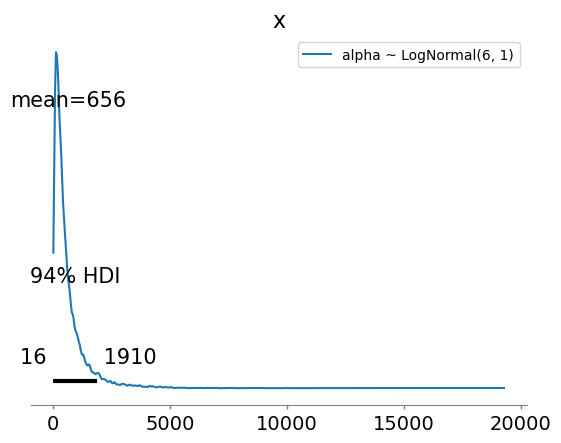

In [7]:
#Maybe this is too fit to the data? 
az.plot_posterior(
    pm.draw(pm.LogNormal.dist(6, 1),draws=20_000),
    label="alpha ~ LogNormal(6, 1)"
)
plt.show();

This  seems like a reasonable prior, since it assigns the 94% HDI of $B$ to be between 10 and 1914 with a mean of 661 bugs.

We therefore define the prior for $\alpha$ to be $\mathrm{Normal}(6, 1)$.

#### Determine prior for $\beta_{L[i]}$ 

In [8]:
df['language'] = df['language'].astype('category')
df['language_code'] = df['language'].cat.codes

In [9]:
with pm.Model() as m_h1_ppc:
    alpha = pm.Normal('alpha', mu=6, sigma=1)
    beta_L = pm.Normal('beta_L', mu=6, sigma=1, shape=len(np.unique(df.language_code)))

    lam = pm.Deterministic('lam', pm.math.exp(alpha + beta_L[df.language_code.values]))

    B = pm.Poisson('B', mu=lam, observed=df_xa.bugs)
    
    m_h1_idata = pm.sample_prior_predictive(samples=500, random_seed=rng)
    
    m_h1_idata.extend(pm.sample(random_seed = rng, idata_kwargs={'log_likelihood': True}))


Sampling: [B, alpha, beta_L]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_L]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'beta_L\n0'}>,
        <Axes: title={'center': 'beta_L\n1'}>],
       [<Axes: title={'center': 'beta_L\n2'}>,
        <Axes: title={'center': 'beta_L\n3'}>,
        <Axes: title={'center': 'beta_L\n4'}>],
       [<Axes: title={'center': 'beta_L\n5'}>,
        <Axes: title={'center': 'beta_L\n6'}>,
        <Axes: title={'center': 'beta_L\n7'}>],
       [<Axes: title={'center': 'beta_L\n8'}>,
        <Axes: title={'center': 'beta_L\n9'}>,
        <Axes: title={'center': 'beta_L\n10'}>],
       [<Axes: title={'center': 'beta_L\n11'}>,
        <Axes: title={'center': 'beta_L\n12'}>,
        <Axes: title={'center': 'beta_L\n13'}>],
       [<Axes: title={'center': 'beta_L\n14'}>,
        <Axes: title={'center': 'beta_L\n15'}>,
        <Axes: title={'center': 'beta_L\n16'}>]], dtype=object)

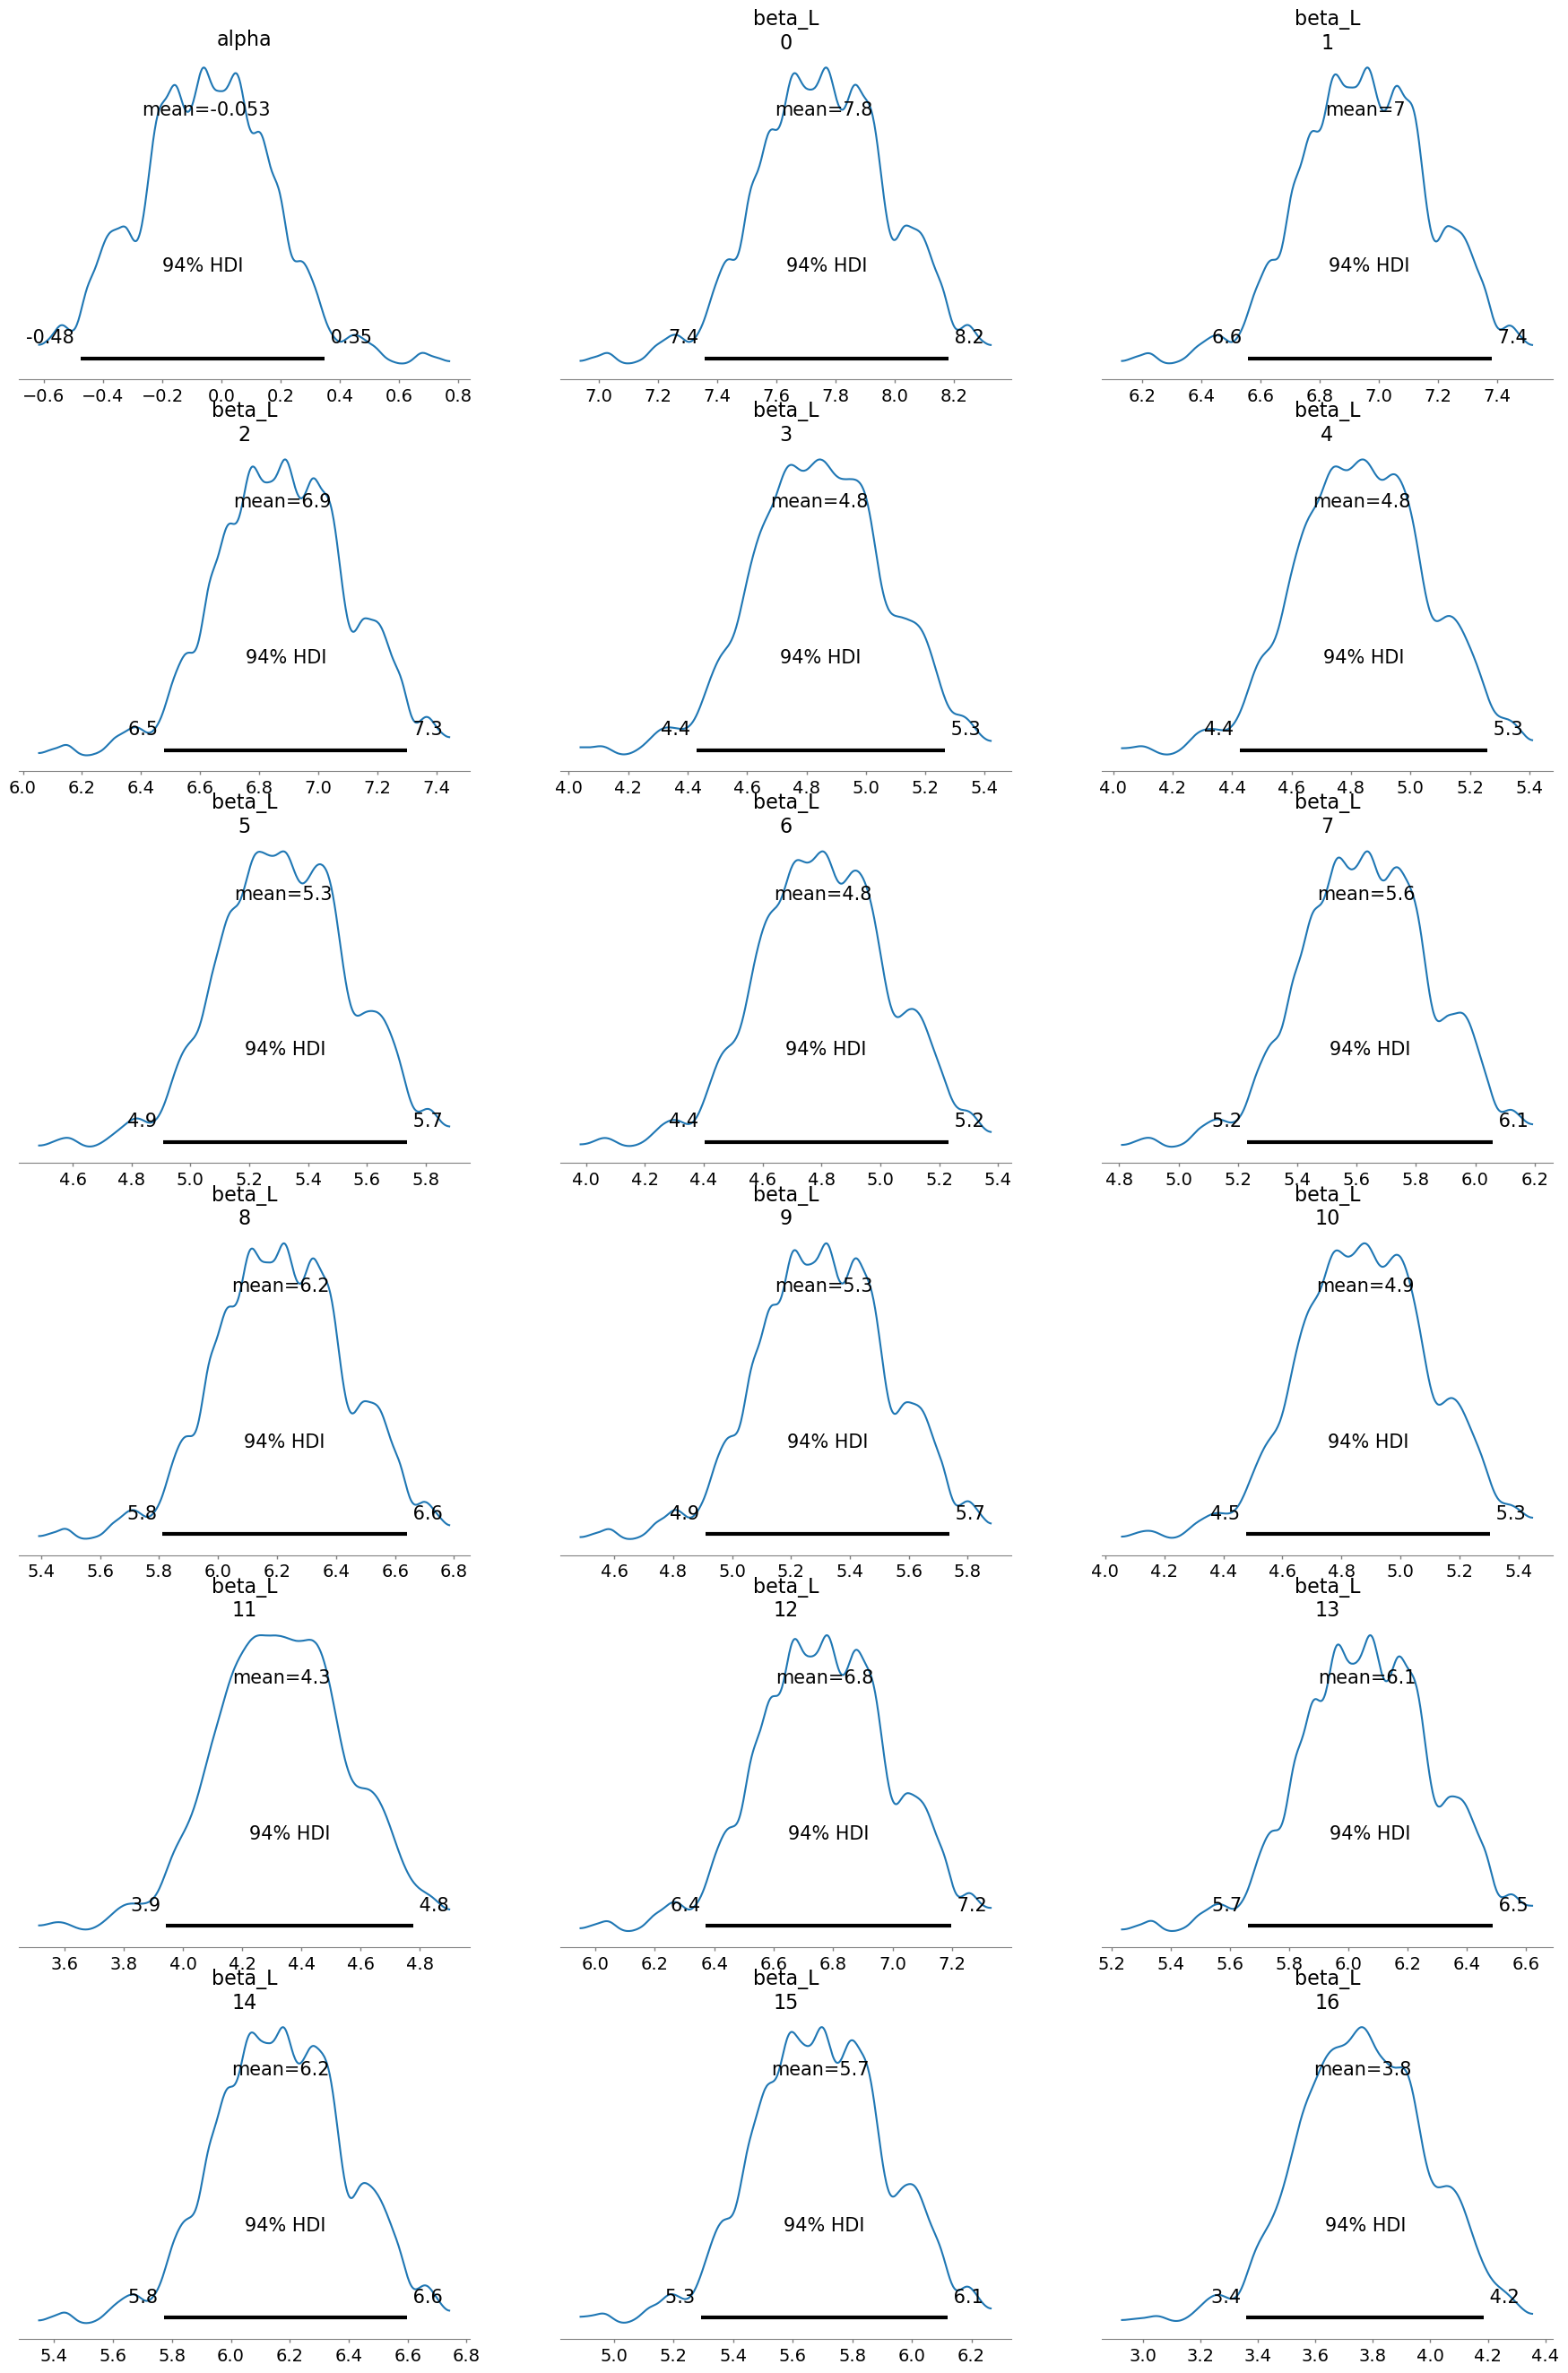

In [11]:
az.plot_posterior(m_h1_idata, var_names=['alpha', 'beta_L'])

## Hypothesis 2

* **H2** - Age (A) has a positive impact on number of bugs (B) for all programming languages (L). That is, projects of old age (A) have larger number of bugs (B). 

In [125]:
def standardize_column(variable):
    # Standardize the column
    standardized_column = (variable - variable.mean()) / variable.std()
    
    return standardized_column

In [126]:
df['age_std'] = standardize_column(df['age'])

We model the number of bugs $B$ with a Poisson distribution.

$$
B_i \sim \mathrm{Poisson}(\lambda_i)
$$

This means that the log-link function is used to connect $B$ to the predictors. We use standardized Age $A$ as a continious predictor. We also add an intercept $\alpha$.

$$
log(\lambda_i) = \alpha + \beta_{A}A_i
$$

We re-use the prior for $\alpha$ that we determined in the section Hypothesis 1.

$$
\alpha \sim \mathrm{Normal}(6, 1)
$$

We determine the prior for $\beta_{A}$ in the following section.

$$
\beta_{A} = \text{Not determined yet}
$$

#### Determine prior for $\beta_A$ 

In [127]:
#We had inspiration from https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_11.ipynb

def prior_plot_poisson(N: int = 100, b_mean: int = 0, b_std: int = 0, ax1=None, ax2=None):
    if ax1 is None:
        _, ax1 = plt.subplots()
        ax1.set_ylabel("Number of bugs")
    #if ax2 is None:
    #    _, ax2 = plt.subplots()
    #    ax2.set_ylabel("Number of bugs")
        
    intercepts = np.random.normal(6, 1, N)
    slopes = np.random.normal(b_mean, b_std, N)
    
    x_seq_std = np.linspace(-3, 3, N) # on std. scale
    #x_seq = np.linspace(np.log(100), np.log(20000), N) # on normal scale
    
    for a, b in zip(intercepts, slopes):
        ax1.plot(x_seq_std, np.exp(a + b * x_seq_std), "k", alpha=0.4)
    ax1.set_xlabel("Age (std)")
    
    #Use for non-std age if it will work
    #for a, b in zip(intercepts, slopes):
    #    ax2.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
    #ax2.set_xlabel("Age")
    
    return ax1

<Axes: xlabel='Age (std)', ylabel='Number of bugs'>

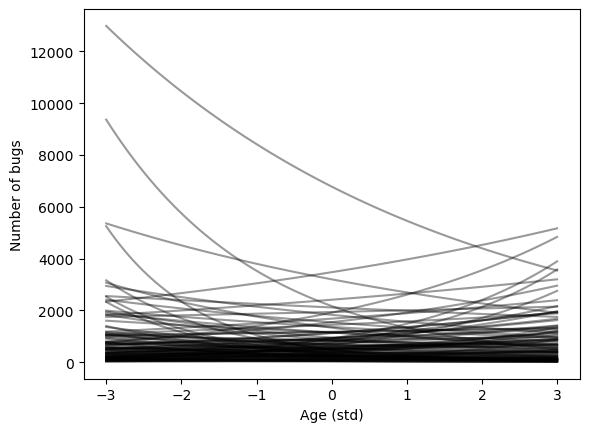

In [128]:
prior_plot_poisson(100, .01, .3)

We determine the prior to be $\beta_A \sim \mathrm{Normal}(0.01, 0.3)$

#### Fit model

In [129]:
with pm.Model() as m_h2:
    alpha = pm.Normal('alpha', mu=6, sigma=1)
    beta_A = pm.Normal('beta_A', mu=0.01, sigma=0.3)
    
    #We add age_std here so we can do predictive plots with it later
    age_std = pm.Data("age_std", df.age_std, mutable=True)
    lam = pm.Deterministic('lam', pm.math.exp(alpha + beta_A * age_std))

    B = pm.Poisson('B', mu=lam, observed=df.bugs)

    m_h2_idata = pm.sample(random_seed = rng, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_A]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta_A'}>,
        <Axes: title={'center': 'beta_A'}>],
       [<Axes: title={'center': 'lam'}>, <Axes: title={'center': 'lam'}>]],
      dtype=object)

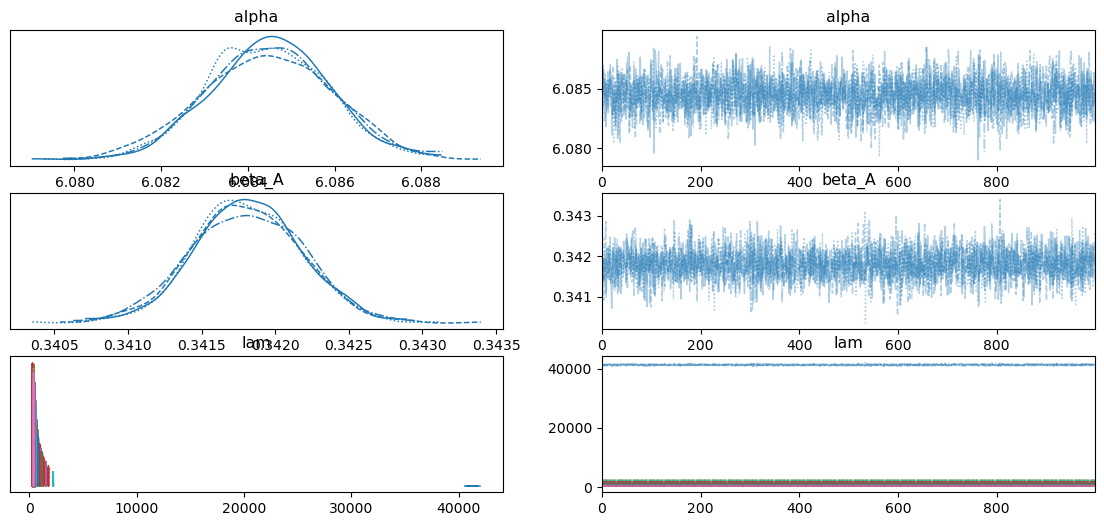

In [130]:
az.plot_trace(m_h2_idata, figsize=(14, 3*2))

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta_A'}>], dtype=object)

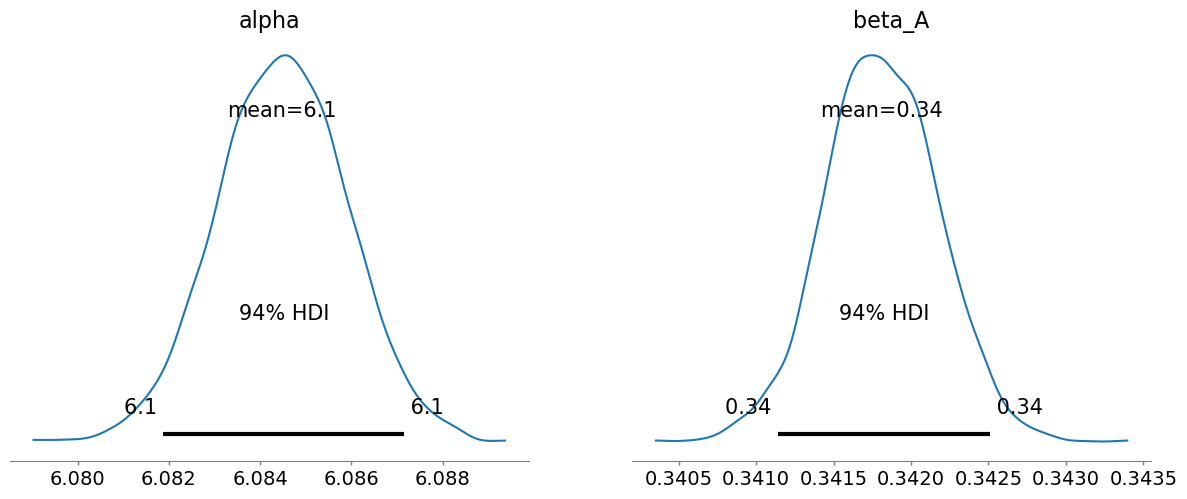

In [131]:
az.plot_posterior(m_h2_idata, var_names=['alpha', 'beta_A'])

#### Posterior Predictive Check

In [132]:
pareto_k = az.loo(m_h2_idata, pointwise=True).pareto_k.values

/Users/eisukeokuda/ENTER/envs/prpro-2024/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [133]:
pareto_k.max()

48.22406097118389

In [134]:
age_seq = np.linspace(-3.0, 3.0, 1127)
with m_h2:
    pm.set_data({"age_std": age_seq})
    post_pred_B = pm.sample_posterior_predictive(m_h2_idata, var_names=["B"])['posterior_predictive']['B']
    
post_pred_B_mean = post_pred_B.mean(["chain", "draw"])

Sampling: [B]


(300.0, 1200.0)

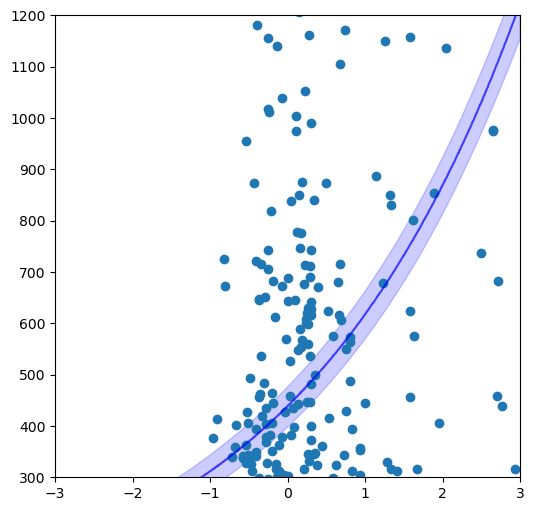

In [135]:
#_, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.figure(figsize=(6,6))

az.plot_hdi(age_seq, post_pred_B, color = 'b', fill_kwargs={'alpha': 0.2}, ax=plt)
plt.plot(age_seq, post_pred_B_mean, color = 'b', alpha=0.7, label='mean')
plt.scatter(df.age_std, df.bugs)


plt.xlim(-3.0,3.0)
plt.ylim(300,1200)

## Hypothesis 3

We model the number of bugs $B$ with a Poisson distribution.

$$
B_i \sim \mathrm{Poisson}(\lambda_i)
$$

This means that the log-link function is used to connect $B$ to the predictors. We use standardized Age $A$ and standardized commits $C$ as a continious predictors. We also add an intercept $\alpha$.

$$
log(\lambda_i) = \alpha + \beta_{A}A_i + \beta_{C}C_i
$$

We re-use the priors that we determined in the section Hypothesis 2.

$$
\alpha \sim \mathrm{Normal}(6, 1)
$$

$$
\beta_A \sim \mathrm{Normal}(0.01, 0.3)
$$

$$
\beta_A \sim \mathrm{Normal}(0.01, 0.3)
$$

In [136]:
df['commits_std'] = standardize_column(df['commits'])

In [50]:
with pm.Model() as m_h3:
    alpha = pm.Normal('alpha', mu=6, sigma=1)
    beta_A = pm.Normal('beta_A', mu=0.01, sigma=0.3)
    beta_C = pm.Normal('beta_C', mu =0.01, sigma=0.3)
    
    #We add age_std and com_std here so we can do predictive plots with it later
    age_std = pm.Data("age_std", df.age_std, mutable=True)
    com_std = pm.Data("com_std", df.commits_std, mutable=True)
    lam = pm.Deterministic('lam', pm.math.exp(alpha + beta_A*age_std + beta_C*com_std))

    B = pm.Poisson('B', mu=lam, observed=df.bugs)

    m_h3_idata = pm.sample(random_seed = rng, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_A, beta_C]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta_A'}>,
        <Axes: title={'center': 'beta_A'}>],
       [<Axes: title={'center': 'beta_C'}>,
        <Axes: title={'center': 'beta_C'}>],
       [<Axes: title={'center': 'lam'}>, <Axes: title={'center': 'lam'}>]],
      dtype=object)

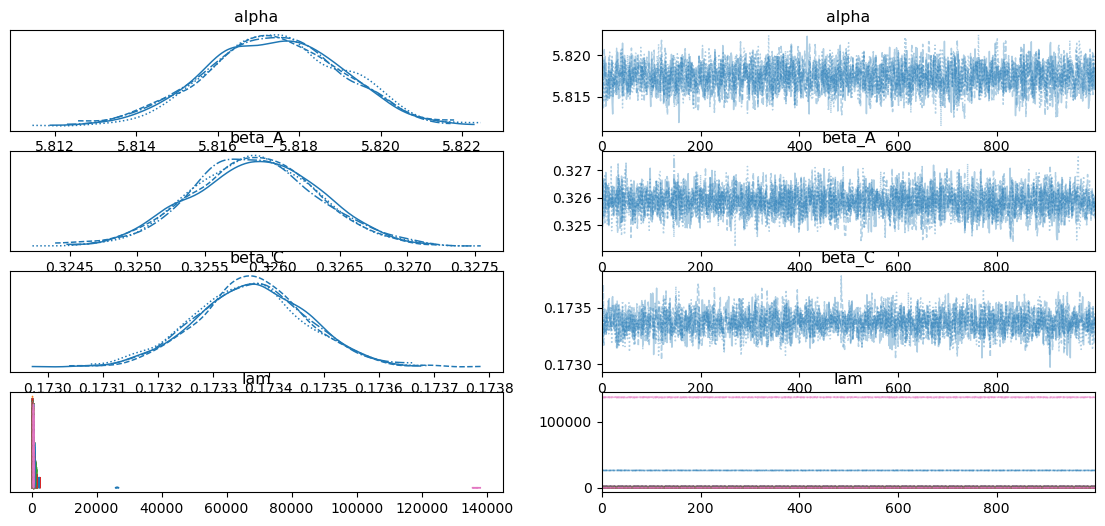

In [51]:
az.plot_trace(m_h3_idata, figsize=(14, 3*2))

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta_A'}>], dtype=object)

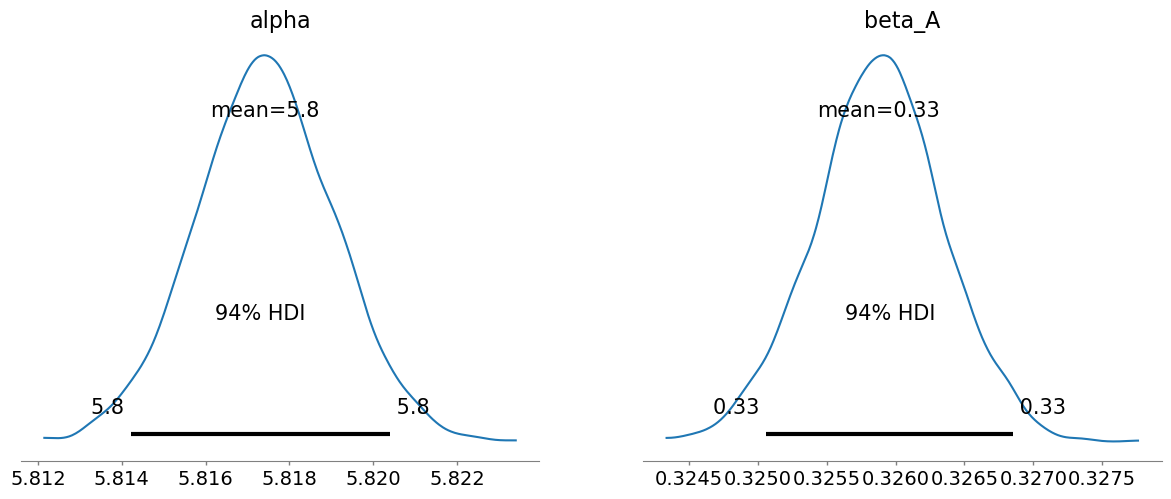

In [84]:
az.plot_posterior(m_h3_idata, var_names=['alpha', 'beta_A'])

In [84]:
with m_h3:
    pm.set_data({"age_std": age_seq})
    post_pred_B = pm.sample_posterior_predictive(m_h3_idata, var_names=["B"])['posterior_predictive']['B']
    
post_pred_B_mean = post_pred_B.mean(["chain", "draw"])

Sampling: [B]


(300.0, 1200.0)

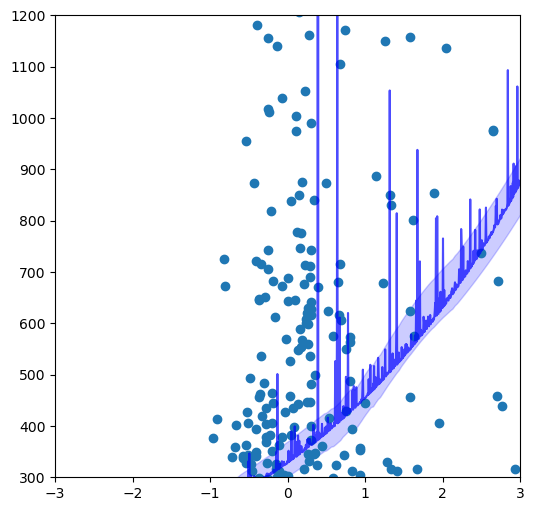

In [85]:
#_, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.figure(figsize=(6,6))

az.plot_hdi(age_seq, post_pred_B, color = 'b', fill_kwargs={'alpha': 0.2}, ax=plt)
plt.plot(age_seq, post_pred_B_mean, color = 'b', alpha=0.7, label='mean')
plt.scatter(df.age_std, df.bugs)


plt.xlim(-3.0,3.0)
plt.ylim(300,1200)

## Modelling bugs as normal distribution

In [137]:
df['bug_std'] = standardize_column(df['bugs'])

### H1

In [229]:
def plot_prior_categorical(b_mean: int = 1, b_std: int = 1, N: int = 100):
    plt.figure()
        
    alphas = np.random.normal(0, 0.2, N)
    betas = np.random.normal(b_mean, b_std, N)
    
    # Plot each line
    for a, b in zip(alphas, betas):
        x_seq = np.array([0, 1])
        plt.plot(x_seq, a + b * x_seq, 'k', alpha=0.4)

    plt.xticks([0, 1])
    plt.xlabel("Language")
    plt.ylabel('Number of bugs')
    
    return plt

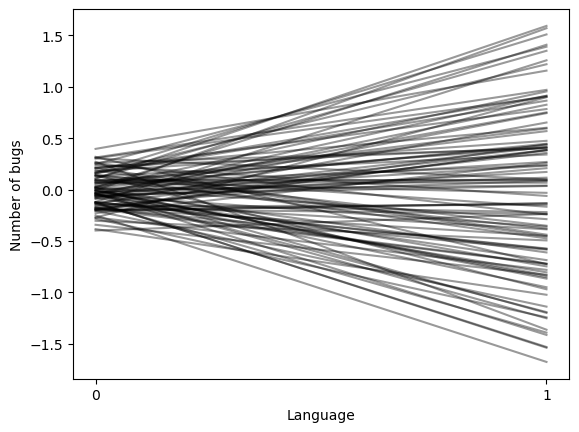

In [233]:
plot_prior_categorical(0, .75);

In [234]:
language_idx, languages = pd.factorize(df.language)

In [239]:
def create_model_h1(alpha_mu_prior, alpha_sigma_prior, beta_mu_prior, beta_sigma_prior, save_name='', save=False):
  '''
  Creates model for hypothesis 1. 
  '''
  with pm.Model() as model:
      # Priors
      alpha = pm.Normal("alpha", mu=alpha_mu_prior, sigma=alpha_sigma_prior)
      beta = pm.Normal('beta',  mu=beta_mu_prior, sigma=beta_sigma_prior, shape=languages.size)
      sigma = pm.Exponential("sigma", 1.0)
      
      #We add language_ids as mutable data so we can change it later in posterior predictions
      language_ids = pm.Data('language_ids', language_idx, mutable=True)

      lam = pm.Deterministic('lam', alpha + beta[language_ids])
      B = pm.Normal('B', mu=lam, sigma=sigma, observed=df.bug_std)
      
      #Sample posterior and prior predictive
      trace = pm.sample(2000, tune=1000, idata_kwargs={'log_likelihood': True}, chains=4)
    
      if save == True:  
        trace.to_netcdf("./traces/"+save_name+"_.nc")

  return trace, model

In [240]:
h1_idata, h1_model = create_model_h1(0, .2, 0, .75)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


In [241]:
#specifying names of the variables
var_names_langauge = list(h1_idata.posterior.data_vars.keys())[:-1]
pm.summary(h1_idata, var_names=var_names_langauge,round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.00,0.13,-0.26,0.24,0.0,0.0,948.23,1960.99,1.01
beta[0],-0.09,0.19,-0.45,0.26,0.0,0.0,1623.82,3070.39,1.01
beta[1],-0.08,0.15,-0.36,0.21,0.0,0.0,1147.65,2249.60,1.01
beta[2],-0.09,0.19,-0.45,0.25,0.0,0.0,1684.94,3542.02,1.01
beta[3],-0.00,0.17,-0.34,0.32,0.0,0.0,1424.55,3120.96,1.01
beta[4],0.09,0.19,-0.27,0.43,0.0,0.0,1580.70,3154.63,1.00
beta[5],0.13,0.19,-0.23,0.48,0.0,0.0,1744.77,3332.94,1.00
beta[6],-0.10,0.23,-0.52,0.34,0.0,0.0,2324.62,3799.71,1.00
beta[7],0.44,0.17,0.13,0.78,0.0,0.0,1399.54,2886.65,1.01
beta[8],0.11,0.17,-0.20,0.43,0.0,0.0,1454.41,2994.14,1.01


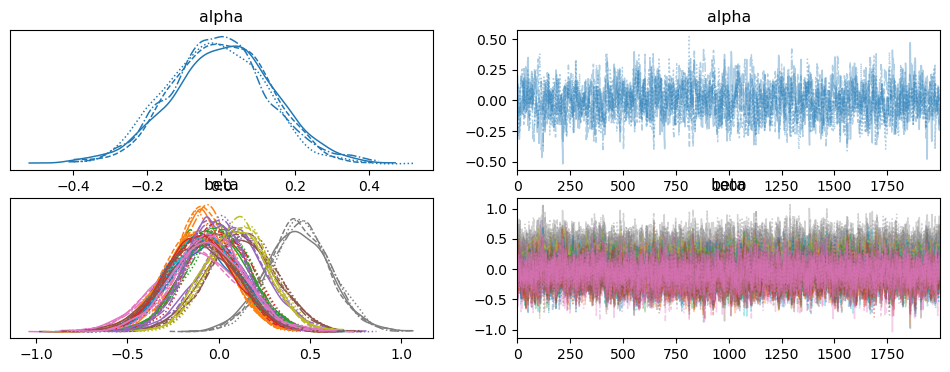

In [242]:
pm.plot_trace(h1_idata, var_names=['alpha','beta']);

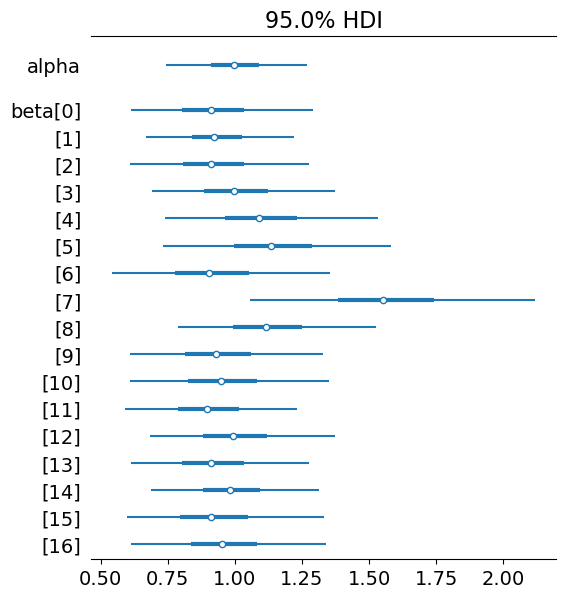

In [243]:
pm.plot_forest(h1_idata, var_names=['alpha','beta'], hdi_prob=.95, combined=True, transform=transform_exp);

In [244]:
#Calculate emperical mean of every language. Use for-loop instead of 'groupby' to maintain index order.
languages_mean = []
for language in languages:
    language_mean = df[df['language']==language]['bugs'].mean()
    languages_mean.append(language_mean)
languages_mean = pd.Series(languages_mean, index=languages)

In [245]:
with h1_model:
    pm.set_data({'language_ids': np.array(range(len(languages)))}) #
    ppc = pm.sample_posterior_predictive(h1_idata, var_names=["lam"])["posterior_predictive"]["lam"]
p_mu = np.array(ppc.mean(["chain", "draw"])) #Take mean
p_mu = pd.Series(p_mu, index=languages)

Sampling: []


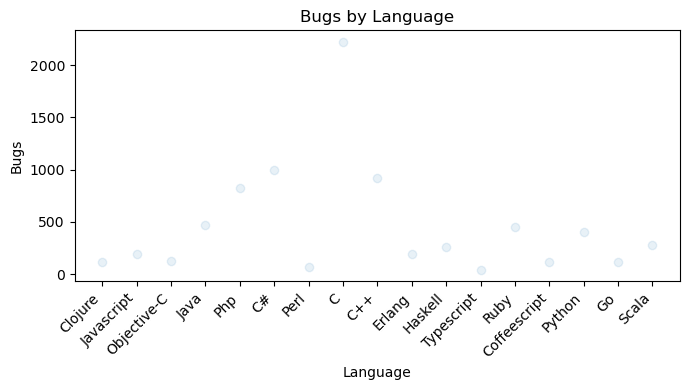

In [247]:
plt.figure(figsize=(7, 4))
plt.scatter(languages_mean.index, languages_mean, alpha=0.1, marker='o')
#plt.scatter(languages_mean.index, p_mu*df.bugs.std()+df.bugs.mean(), alpha=0.1, marker='s')
plt.scatter
plt.title('Bugs by Language')
plt.xlabel('Language')
plt.ylabel('Bugs')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

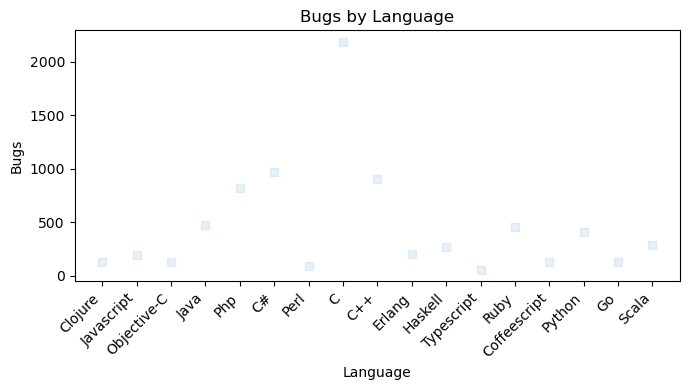

In [252]:
plt.figure(figsize=(7, 4))
#plt.scatter(languages_mean.index, languages_mean, alpha=0.1, marker='o')
plt.scatter(languages_mean.index, p_mu*df.bugs.std()+df.bugs.mean(), alpha=0.1, marker='s')
plt.title('Bugs by Language')
plt.xlabel('Language')
plt.ylabel('Bugs')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

### H2

In [202]:
#We had inspiration from https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_11.ipynb

def prior_plot_normal(N: int = 100, b_mean: int = 0, b_std: int = 0, ax1=None, ax2=None):
    if ax1 is None:
        _, ax1 = plt.subplots()
        ax1.set_ylabel("# of bugs (std)")
    #if ax2 is None:
    #    _, ax2 = plt.subplots()
    #    ax2.set_ylabel("Number of bugs")
        
    intercepts = np.random.normal(0, 0.2, N)
    slopes = np.random.normal(b_mean, b_std, N)
    
    x_seq_std = np.linspace(-3, 3, N) # on std. scale
    #x_seq = np.linspace(np.log(100), np.log(20000), N) # on normal scale
    
    for a, b in zip(intercepts, slopes):
        ax1.plot(x_seq_std, a + b * x_seq_std, "k", alpha=0.4)
    ax1.set_xlabel("Age (std)")
    
    #Use for non-std age if it will work
    #for a, b in zip(intercepts, slopes):
    #    ax2.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
    #ax2.set_xlabel("Age")
    
    return ax1

<Axes: xlabel='Age (std)', ylabel='# of bugs (std)'>

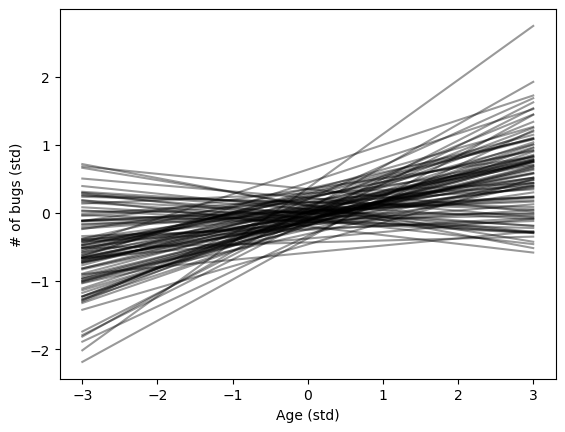

In [203]:
prior_plot_normal(100, 0.2, 0.2)

In [204]:
with pm.Model() as h2_normal:
    alpha = pm.Normal('alpha', mu=0, sigma=0.2)
    beta_A = pm.Normal('beta_A', mu=0.2, sigma=0.2)
    sigma = pm.Exponential("sigma", 1.0)
    
    #We add age_std and com_std here so we can do predictive plots with it later
    age_std = pm.Data("age_std", df.age_std, mutable=True)
    mu = pm.Deterministic('mu', alpha + beta_A*age_std)

    B = pm.Normal('B_std', mu=mu,  sigma=sigma, observed=df.bug_std)

    h2_idata = pm.sample(random_seed = rng, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_A, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [205]:
#specifying names of the variables
var_names_langauge = list(h2_idata.posterior.data_vars.keys())[:-1]
pm.summary(h2_idata, var_names=var_names_langauge,round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.00,0.03,-0.06,0.05,0.0,0.0,5887.73,2675.67,1.0
beta_A,0.17,0.03,0.12,0.23,0.0,0.0,5646.12,3336.29,1.0
sigma,0.99,0.02,0.95,1.03,0.0,0.0,6320.08,3213.91,1.0


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta_A'}>,
        <Axes: title={'center': 'beta_A'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

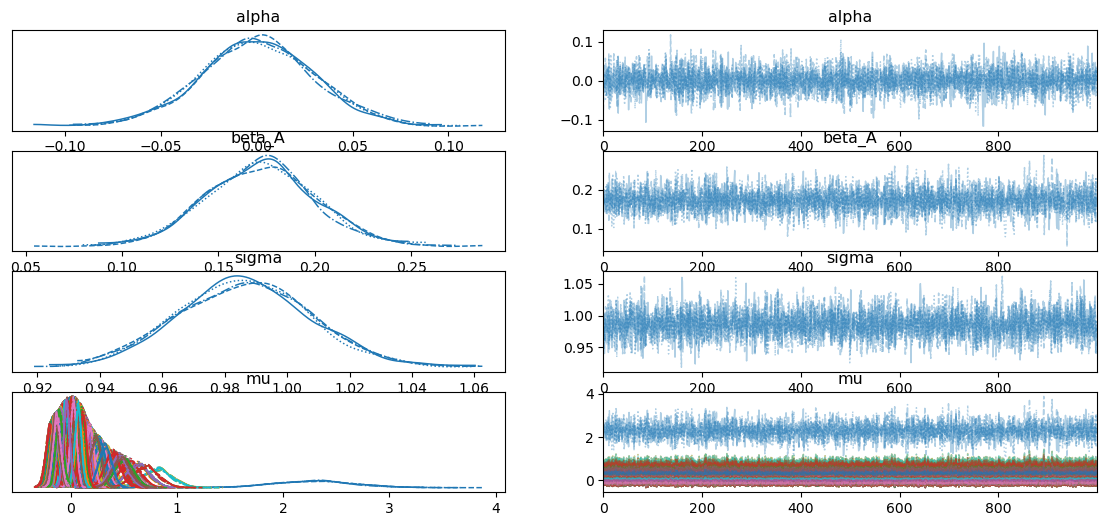

In [206]:
az.plot_trace(h2_idata, figsize=(14, 3*2))

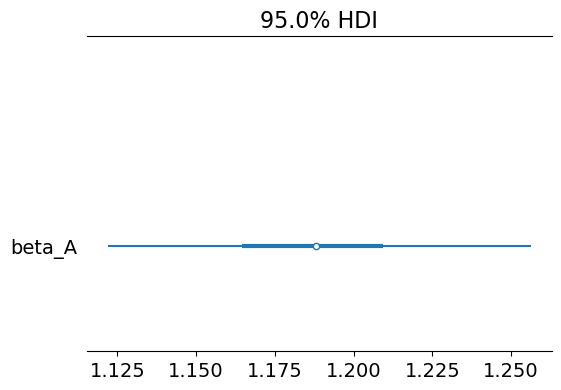

In [207]:
az.plot_forest(h2_idata, var_names = ['beta_A'], hdi_prob=.95, combined=True, transform=transform_exp);

In [208]:
n_points = len(df)
x_seq = np.linspace(-1.5, 5, n_points)

with h2_normal:
    pm.set_data({"age_std": x_seq})
    post_pred_B = pm.sample_posterior_predictive(h2_idata, var_names=["B_std"])['posterior_predictive']['B_std']
    
post_pred_B_mean = post_pred_B.mean(["chain", "draw"])

Sampling: [B_std]


Text(0, 0.5, 'Bugs')

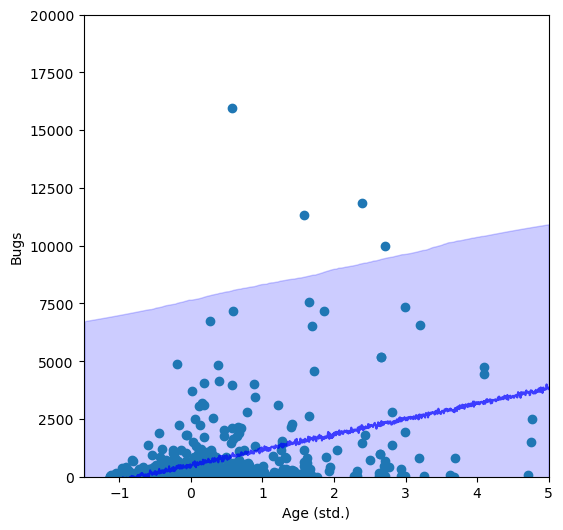

In [209]:
#_, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.figure(figsize=(6,6))

az.plot_hdi(x_seq, post_pred_B*df.bugs.std()+df.bugs.mean(), color = 'b', fill_kwargs={'alpha': 0.2}, ax=plt)
plt.plot(x_seq, post_pred_B_mean*df.bugs.std()+df.bugs.mean(), color = 'b', alpha=0.7, label='mean')
plt.scatter(df.age_std, df.bugs)


plt.xlim(-1.5,5.0)
plt.ylim(0,20000)
plt.xlabel('Age (std.)')
plt.ylabel('Bugs')

### H3

In [154]:
with pm.Model() as m_h4:
    alpha = pm.Normal('alpha', mu=0, sigma=0.2)
    beta_A = pm.Normal('beta_A', mu=0.2, sigma=0.2)
    beta_C = pm.Normal('beta_C', mu =0.2, sigma=0.2)
    sigma = pm.Exponential("sigma", 1.0)
    
    #We add age_std and com_std here so we can do predictive plots with it later
    age_std = pm.Data("age_std", df.age_std, mutable=True)
    com_std = pm.Data("com_std", df.commits_std, mutable=True)
    mu = pm.Deterministic('mu', alpha + beta_A*age_std + beta_C*com_std)

    B = pm.Normal('B_std', mu=mu,  sigma=sigma, observed=df.bug_std)

    m_h4_idata = pm.sample(random_seed = rng, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_A, beta_C, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [200]:
#specifying names of the variables
var_names_langauge = list(m_h4_idata.posterior.data_vars.keys())[:-1]
pm.summary(m_h4_idata, var_names=var_names_langauge,round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.00,0.0,-0.01,0.01,0.0,0.0,7319.14,3172.25,1.0
beta_A,0.01,0.0,-0.00,0.01,0.0,0.0,6673.31,3031.11,1.0
beta_C,0.99,0.0,0.99,1.00,0.0,0.0,7144.33,3457.24,1.0
sigma,0.11,0.0,0.11,0.11,0.0,0.0,7191.77,3535.61,1.0


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta_A'}>,
        <Axes: title={'center': 'beta_A'}>],
       [<Axes: title={'center': 'beta_C'}>,
        <Axes: title={'center': 'beta_C'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

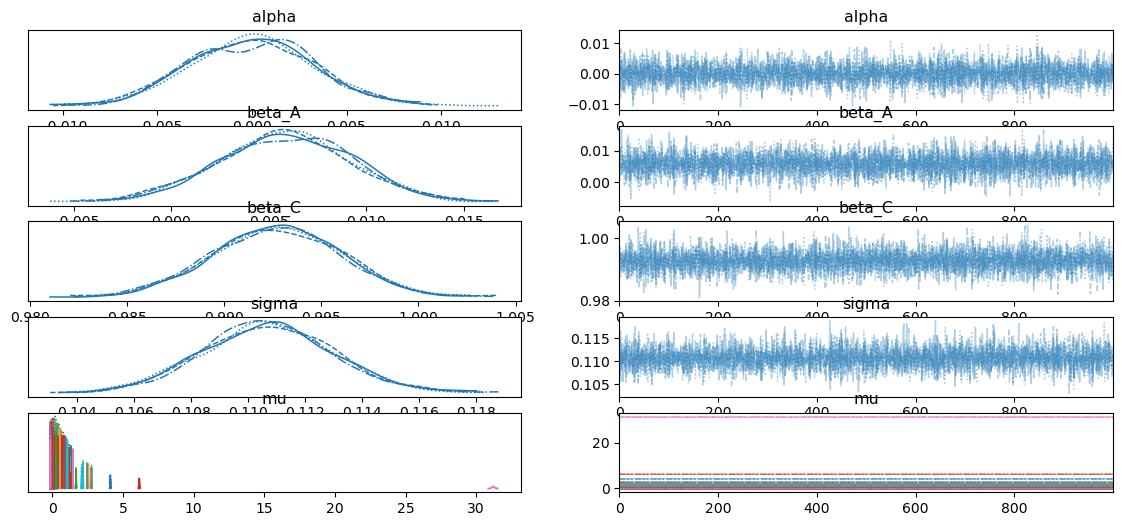

In [155]:
az.plot_trace(m_h4_idata, figsize=(14, 3*2))

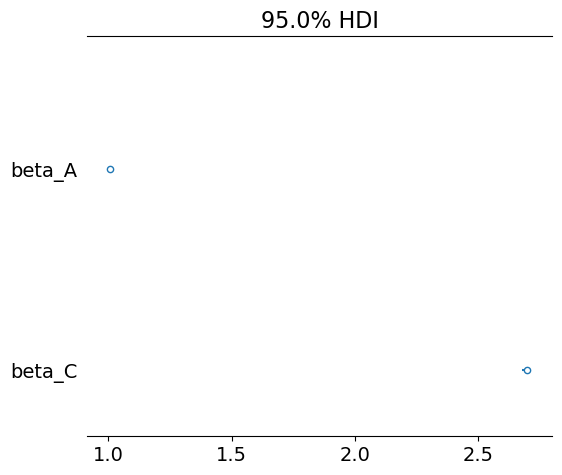

In [161]:
az.plot_forest(m_h4_idata, var_names = ['beta_A', 'beta_C'], hdi_prob=.95, combined=True, transform=transform_exp);

In [194]:
n_points = len(df)
x_seq = np.linspace(-1.5, 5, n_points)

with m_h4:
    pm.set_data({"age_std": x_seq, "com_std": np.repeat(0, n_points)})
    post_pred_B = pm.sample_posterior_predictive(m_h4_idata, var_names=["B_std"])['posterior_predictive']['B_std']
    
post_pred_B_mean = post_pred_B.mean(["chain", "draw"])

Sampling: [B_std]


Text(0, 0.5, 'Bugs (std.)')

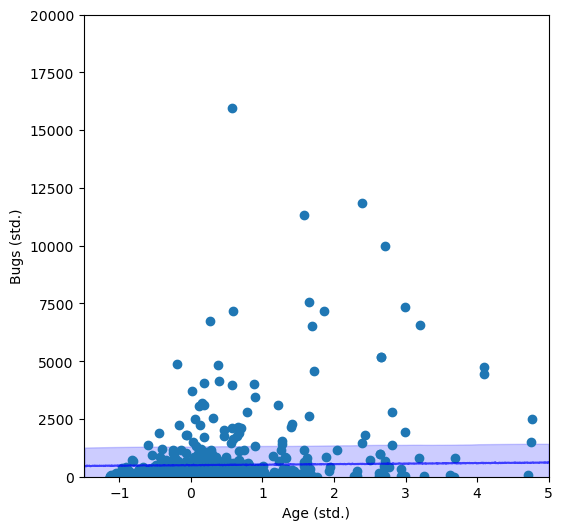

In [195]:
#_, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.figure(figsize=(6,6))

az.plot_hdi(x_seq, post_pred_B*df.bugs.std()+df.bugs.mean(), color = 'b', fill_kwargs={'alpha': 0.2}, ax=plt)
plt.plot(x_seq, post_pred_B_mean*df.bugs.std()+df.bugs.mean(), color = 'b', alpha=0.7, label='mean')
plt.scatter(df.age_std, df.bugs)


plt.xlim(-1.5,5.0)
plt.ylim(0,20000)
plt.xlabel('Age (std.)')
plt.ylabel('Bugs')

In [196]:
n_points = len(df)
x_seq = np.linspace(-1.5, 5, n_points)
min_commits_std = df['age_std'].min() # I dont know if this is correct?

with m_h4:
    pm.set_data({"com_std": x_seq, "age_std": np.repeat(0, n_points)})
    post_pred_B = pm.sample_posterior_predictive(m_h4_idata, var_names=["B_std"])['posterior_predictive']['B_std']
    
post_pred_B_mean = post_pred_B.mean(["chain", "draw"])

Sampling: [B_std]


Text(0, 0.5, 'Bugs (std.)')

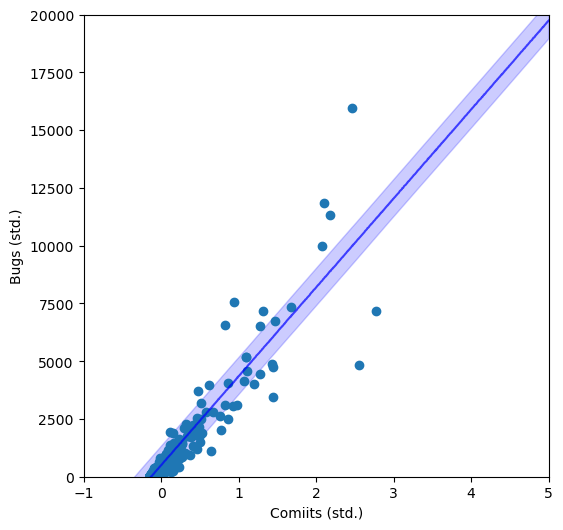

In [198]:
#_, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.figure(figsize=(6,6))

az.plot_hdi(x_seq, post_pred_B*df.bugs.std()+df.bugs.mean(), color = 'b', fill_kwargs={'alpha': 0.2}, ax=plt)
plt.plot(x_seq, post_pred_B_mean*df.bugs.std()+df.bugs.mean(), color = 'b', alpha=0.7, label='mean')
plt.scatter(df.commits_std, df.bugs)


plt.xlim(-1.0,5.0)
plt.ylim(0,20000)
plt.xlabel('Comiits (std.)')
plt.ylabel('Bugs')